## Library

In [1]:
!pip install gpytorch triton

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2
from typing import Type

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from triton.ops import attention

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Init GPU

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Config Info

In [6]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
INDUCING_POINTS = 128

# TARGET_LABELS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
TARGET_LABELS = ['intraparenchymal']

MODEL_PATH = 'trained_model.pth'
DEVICE = 'cuda'

In [7]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")

DATA_DIR = '/kaggle/input/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training/'
CSV_PATH = DATA_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)

Running locally


## Data Preprocessing

In [8]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    return bsb_img.astype(np.float16)

In [9]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        return multichannel_slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [10]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Dataset and DataLoader

### Splitting the Dataset

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

### Processing the Data

In [12]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        # Ensure we have enough slices to create the specified instances
        if len(slices) < depth * num_instances:
            print(f"Not enough slices for patient {patient_id}: found {len(slices)}, needed {depth * num_instances}")
            return None, None
        
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        # Stack preprocessed slices into an array
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (num_slices, height, width, channels)
        
        # Reshape to (num_instances, depth, height, width, channels)
        # reshaped_slices = preprocessed_slices[:num_instances * depth].reshape(num_instances, depth, *preprocessed_slices.shape[1:])  # (num_instances, depth, height, width, channels)
        
        # Labeling remains consistent  
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        # return reshaped_slices, label
        return preprocessed_slices, label
    
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

In [13]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

In [14]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE, shuffle=True):
    train_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

### Sparse Gaussian Process Regression

In [15]:
class SparseGPLayer(ApproximateGP):
    def __init__(self, num_inputs, num_inducing=INDUCING_POINTS):
        # Initialize inducing points
        inducing_points = torch.randn(num_inducing, num_inputs)
        
        # Initialize variational parameters
        variational_distribution = CholeskyVariationalDistribution(num_inducing)
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        
        super(SparseGPLayer, self).__init__(variational_strategy)
        
        # Mean and covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
class SparseGPWrapper(nn.Module):
    def __init__(self, num_inputs, num_inducing=INDUCING_POINTS):
        super(SparseGPWrapper, self).__init__()
        self.gp_layer = SparseGPLayer(num_inputs, num_inducing)
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
    def forward(self, x):
        # Get the GP output
        gp_output = self.gp_layer(x)
        # Return the mean of the GP output
        return gp_output.mean

### Attention Layer

In [17]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = F.softmax(attention_weights, dim=1)
        
        return (x * weights).sum(dim=1), weights.squeeze(-1)

In [18]:
class GatedAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GatedAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))
        
        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)
        
        return (x * weights).sum(dim=1), weights.squeeze(-1)

### Sparse Gaussian Process Layer

In [19]:
class SparseGPlayer(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        inducing_points = inducing_points.to(device)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SparseGPlayer, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean().to(device)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()).to(device)
    
    def forward(self, x):
        x = x.to(device)
        
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### ResNet2D Model

#### Basic Block

In [20]:
class BasicBlock2D(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None,
        dropout_rate: float = 0.25
    ) -> None:
        super(BasicBlock2D, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

#### ResNet2D Model

In [21]:
class ResNet2D_MIL(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock2D],
        num_classes: int = 1,
        dropout_rate: float = 0.25
    ) -> None:
        super(ResNet2D_MIL, self).__init__()
        
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        elif num_layers == 34:
            layers = [3, 4, 6, 3]
            self.expansion = 1
        elif num_layers == 50:
            layers = [3, 4, 6, 3]
            self.expansion = 4
        else:
            raise ValueError("Unsupported number of layers")
        
        self.in_channels = 16
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 32, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 32, layers[3], stride=2, dropout_rate=dropout_rate)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.attention = AttentionLayer(32*self.expansion, 64)
        self.fc = nn.Linear(32*self.expansion, num_classes)

    def _make_layer(
        self, 
        block: Type[BasicBlock2D],
        out_channels: int,
        blocks: int,
        stride: int = 1,
        dropout_rate: float = 0.25
    ) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.in_channels != out_channels * self.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample, dropout_rate
            )
        )
        self.in_channels = out_channels * self.expansion
        for _ in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion,
                dropout_rate=dropout_rate
            ))
        
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # Input shape assertion
        assert x.dim() == 5, f"Expected 5D input (batch_size, num_instances, height, width, channels), but got {x.dim()}D input; x.shape={x.shape}"
        batch_size, num_instances, h, w, c = x.size()
        
        # Reshape to (batch_size * num_instances, channels, height, width)
        out = x.view(batch_size * num_instances, c, h, w)
        
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        
        # Reshape back to (batch_size, num_instances, features)
        out = out.view(batch_size, num_instances, -1)
        
        # out = torch.max(out, dim=1)[0]  # Take max across instances
        
        # Take mean across instances
        # out = out.mean(dim=1)
        
        out, _ = self.attention(out)
        
        out = self.fc(out)
        
        # Assert that the output shape is correct
        assert out.shape == (batch_size, self.fc.out_features), f"Expected output shape (batch_size, {self.fc.out_features}), but got {out.shape}"
        
        return out


def ResNet2D18_MIL(img_channels: int = 3, num_classes: int = 1, dropout_rate: float = 0.25):
    return ResNet2D_MIL(img_channels, 18, BasicBlock2D, num_classes, dropout_rate)

def ResNet2D34_MIL(img_channels: int = 3, num_classes: int = 1, dropout_rate: float = 0.25):
    return ResNet2D_MIL(img_channels, 34, BasicBlock2D, num_classes, dropout_rate)

def ResNet2D50_MIL(img_channels: int = 3, num_classes: int = 1, dropout_rate: float = 0.25):
    return ResNet2D_MIL(img_channels, 50, BasicBlock2D, num_classes, dropout_rate)


## Training and Evaluation

### Training

In [22]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0.0
    predictions = []
    labels = []

    for batch_data, batch_labels in data_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(batch_data).squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predictions.extend((outputs > 0).cpu().numpy())
        labels.extend(batch_labels.cpu().numpy())

    return total_loss, predictions, labels

def validate(model, data_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            loss = criterion(outputs, batch_labels)

            total_loss += loss.item()
            predictions.extend((outputs > 0).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return total_loss, predictions, labels

def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)

    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, val_loader, criterion, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    return model

### Evaluation Functions

In [23]:
## Model Evaluation Functions
def evaluate_model(model, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            predictions.extend((outputs > 0).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)

def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [24]:
## Visualization Functions
def plot_roc_curve(model, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    # predictions, labels = evaluate_model(model, data_loader, device)
    
    model.eval()
    labels = []
    predictions = []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            predictions.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [25]:
## Data Processing Functions
def load_model(model_class, model_path):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class()
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Main

Epoch 1/30 - Train:
Loss: 60.5092, Accuracy: 0.5329, Precision: 0.5906, Recall: 0.2143, F1: 0.3145
Epoch 1/30 - Validation:
Loss: 27.0445, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Epoch 2/30 - Train:
Loss: 57.5028, Accuracy: 0.6129, Precision: 0.6076, Recall: 0.6371, F1: 0.6220
Epoch 2/30 - Validation:
Loss: 29.3139, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Epoch 3/30 - Train:
Loss: 54.4625, Accuracy: 0.6671, Precision: 0.6594, Recall: 0.6914, F1: 0.6750
Epoch 3/30 - Validation:
Loss: 35.7120, Accuracy: 0.5533, Precision: 0.9000, Recall: 0.1200, F1: 0.2118
Epoch 4/30 - Train:
Loss: 54.4475, Accuracy: 0.6714, Precision: 0.6648, Recall: 0.6914, F1: 0.6779
Epoch 4/30 - Validation:
Loss: 25.4970, Accuracy: 0.5667, Precision: 0.5362, Recall: 0.9867, F1: 0.6948
Epoch 5/30 - Train:
Loss: 52.8548, Accuracy: 0.6757, Precision: 0.6649, Recall: 0.7086, F1: 0.6860
Epoch 5/30 - Validation:
Loss: 34.6457, Accuracy: 0.5600, Precision: 0.9091, Recall: 0.13

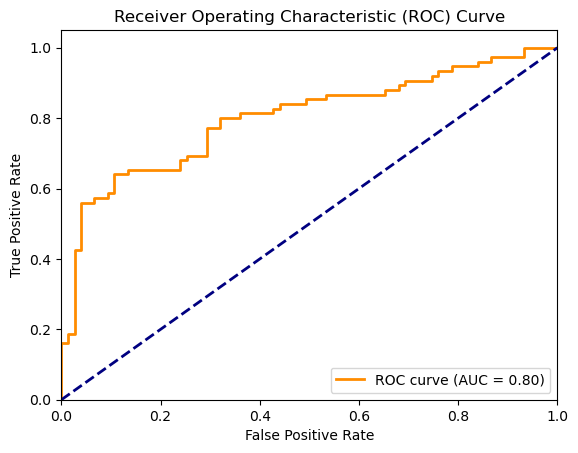

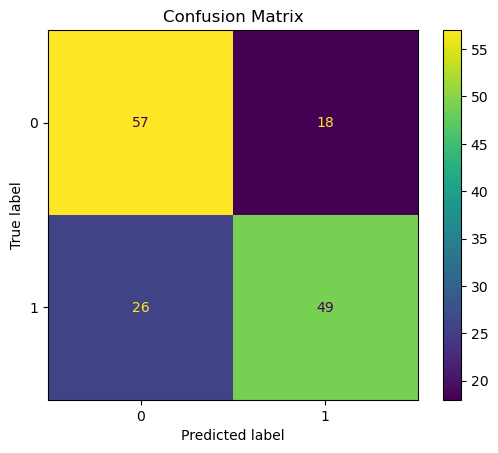

    patient_id study_instance_uid  label  prediction
0  ID_0748e0c1      ID_286183702b      0        True
1  ID_1528ff50      ID_5d0a50f3db      1       False
2  ID_07d4f582      ID_8b1137e5bc      0       False
3  ID_03131dd0      ID_a4ed78f57e      0       False
4  ID_05e0a4a1      ID_9dd14f9fa3      1        True


In [26]:
## Main Execution
def main():
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    
    # Initialize model, criterion, and optimizer
    model = ResNet2D18_MIL()  # Assuming this is your model class
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train model
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, LEARNING_RATE, DEVICE)
    
    # Save model
    torch.save(trained_model.state_dict(), MODEL_PATH)
    
    # Load best model
    trained_model = load_model(ResNet2D18_MIL, MODEL_PATH)

    # Evaluate model
    predictions, labels = evaluate_model(trained_model, test_loader, DEVICE)
    metrics = calculate_metrics(predictions, labels)
    print_metrics(metrics)
    
    # Visualizations
    plot_roc_curve(trained_model, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, test_loader, DEVICE)

    # Select only the required columns
    required_columns = ['patient_id', 'study_instance_uid', 'label']
    test_labels = test_labels[required_columns]
    
    # Save results
    results_df = get_test_results(trained_model, test_loader, test_labels)
    results_df.to_csv('results.csv', index=False)
    print(results_df.head())


if __name__ == "__main__":
    main()

## Visualizing Attention Weights and Images

### Show Attention Weights and Images for a Single Patient

In [27]:
# Function to test a single patient
def test_single_patient(model, patient_data):
    model.eval()
    with torch.no_grad():
        for batch_data, batch_labels in patient_data:
            batch_data = batch_data.to(device)  # Move data to device
            outputs, gated_attention = model(batch_data)  # Get outputs and attention weights
            outputs = outputs.squeeze()  # Remove extra dimension
            
            predictions = (outputs > 0).cpu().numpy()
            
            print("Predictions:", predictions)
            print("Labels: ", batch_labels.cpu().numpy())
            # Print attention weights
            attention_weights_np = gated_attention.cpu().numpy()  # Move to CPU for easier handling
            print("Attention Weights for Slides:")
            
            for i in range(attention_weights_np.shape[1]):  # Iterate over instances/slides
                print(f'Slide {i+1}: Attention Weight: {attention_weights_np[0][i][0]}')  # Print weight for each slide
                
            # Plot the images
            plot_images(batch_data[0].cpu(), batch_labels[0].cpu())
            
            break  # Only test one patient

In [28]:
def plot_images(images, labels):
    print(images.shape)
    batch_size, num_images_per_batch, height, width, channels = images.shape
    images = images.view(batch_size * num_images_per_batch, height, width, channels)
    
    print(f'Images shape: {images.shape}')
    num_images = images.size(0) 
    images = images.numpy()
    
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()
    
# # Call the function with the test_loader
# test_loader = get_test_loader(dicom_dir, test_labels, batch_size=2)
# test_single_patient(trained_model, test_loader)